Dask client dashboard is available at: http://localhost:8787/
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')


100%|██████████| 10000/10000 [00:36<00:00, 272.27it/s]


Total Bound Fraction:138/99998298 or 1.3800234879997658e-06, Approximately 1 bound ISO per 579075.4788493561 years. Theoretical Fraction bound: 1.4100239986084562e-06, Accuracy: 97.82608695652173


100%|██████████| 23/23 [00:00<00:00, 2518.05it/s]


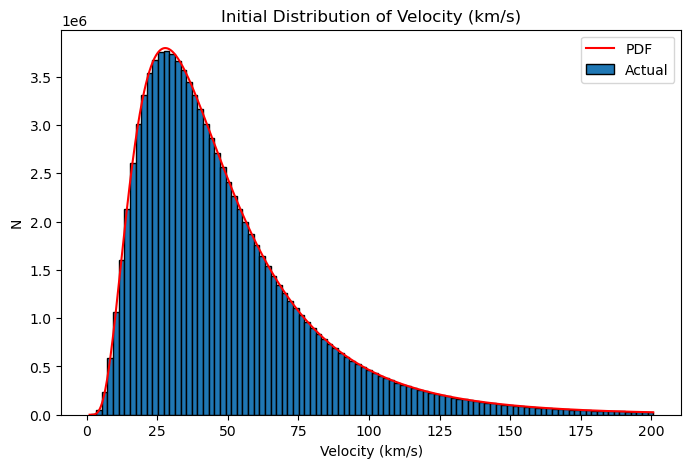

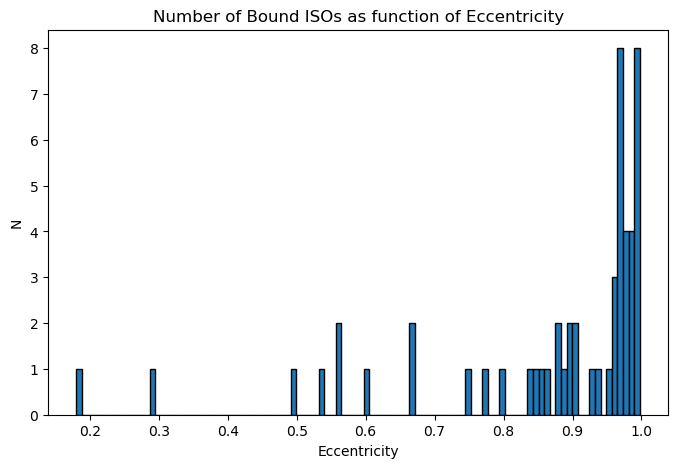

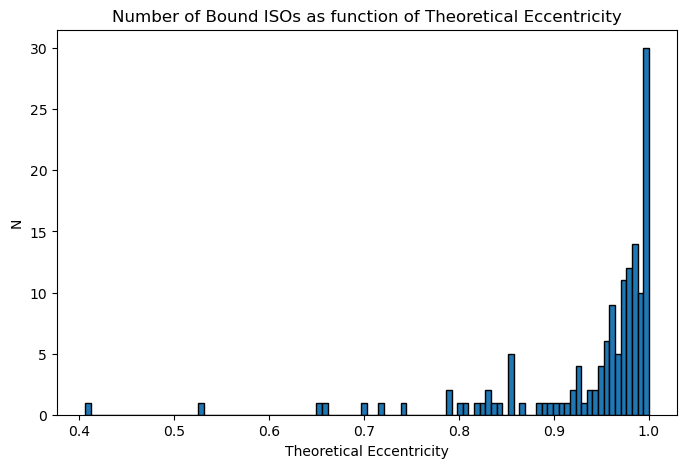

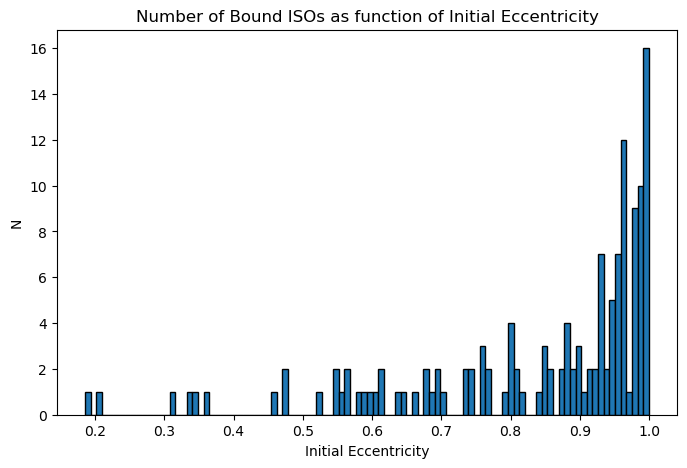

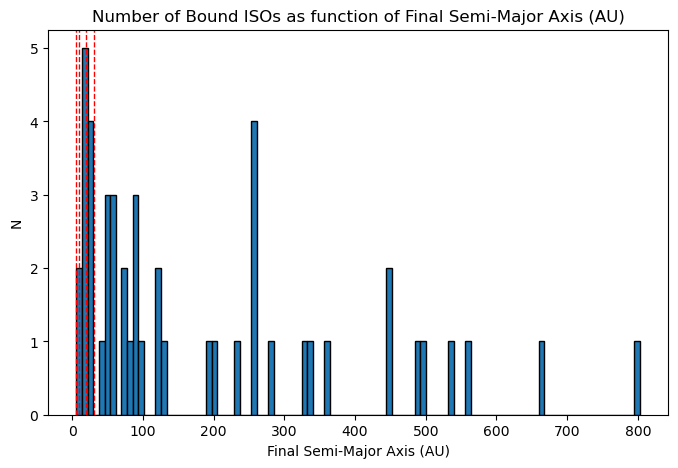

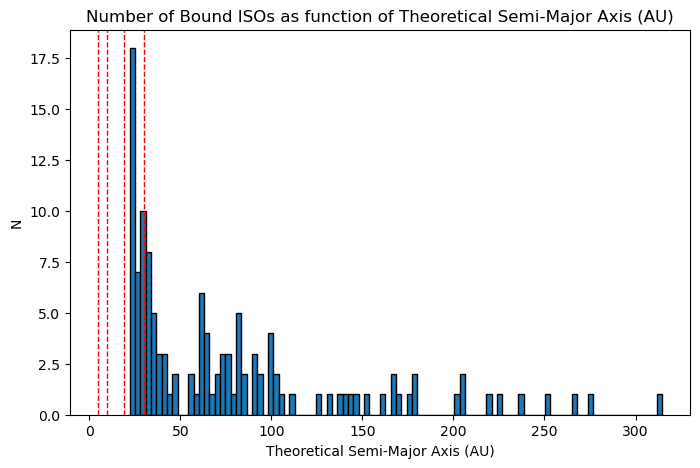

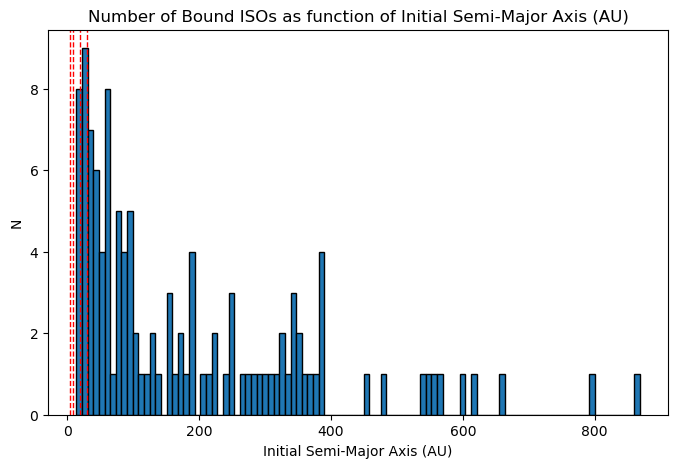

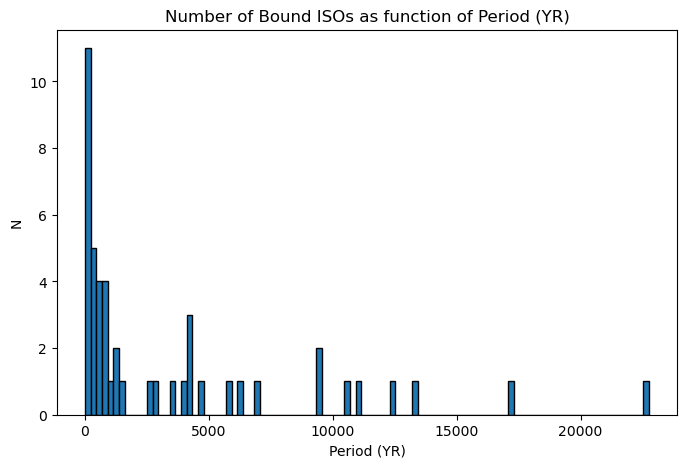

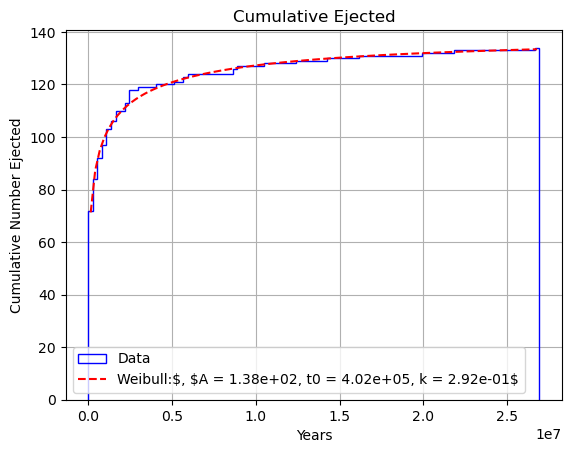

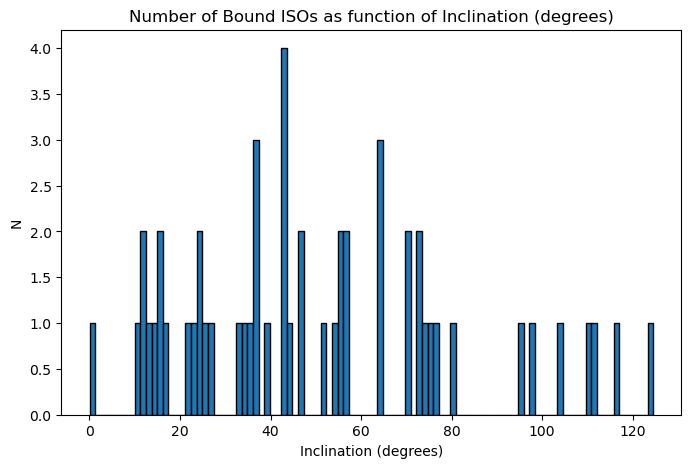

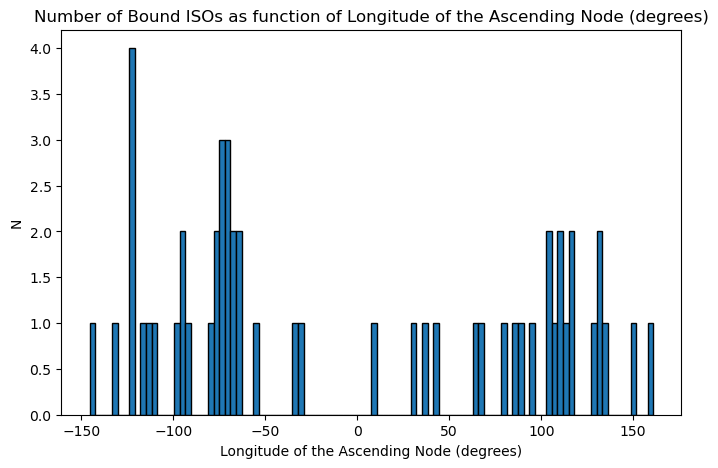

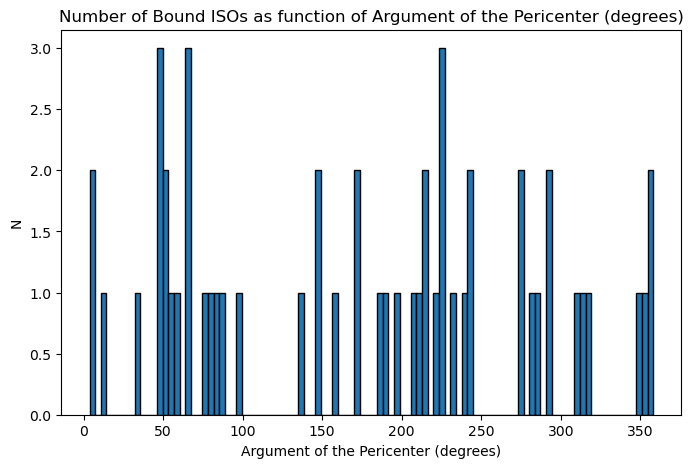

/var/folders/y6/0lj8z12j33x7bgfq4n9lnxc80000gq/T/ipykernel_9755/2403613582.py:733: RuntimeWarning: invalid value encountered in sqrt
  TJ3 = np.sqrt((1-((3 - (5.2029/x))/2)**2 * (5.2029/x)))


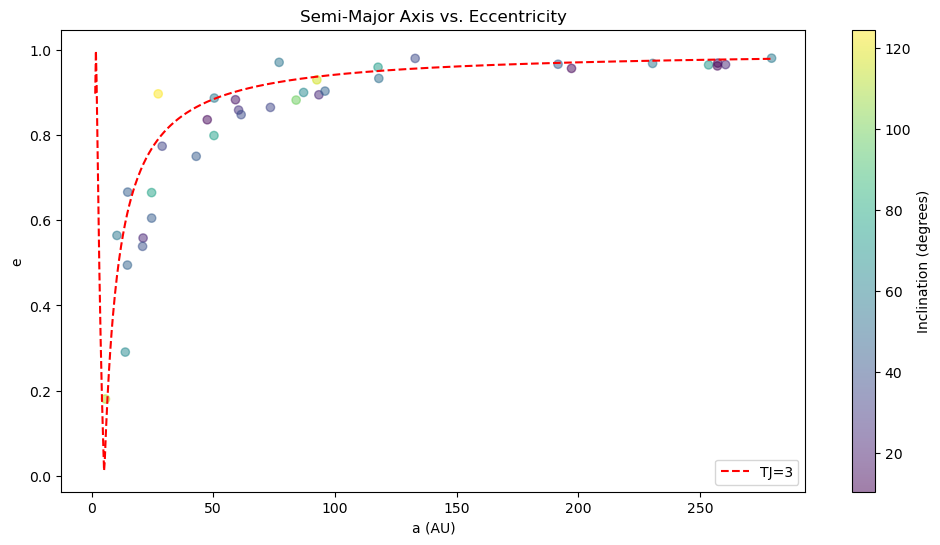

Approximate Current Number of Bound ISOs in Our Solar System Due to Saturn: 2


In [1]:
"""
***********************************
V1.4
JUPITER VOLUME CAPTURE RATE OF ISOs
***********************************
Python code for numerical simulations to derive the capture cross-section of Jupiter and calculate volume capture 
rate via close-encounters with Jupiter and interstellar objects, as well as the the stability of bound orbits.
By Rainer Marquardt-Demen
*******
Imports:
*******
-OS: Operating system, used to save to file
-UUID: Unique identifiers for saving to file
-REBOUND (RB): Main simulation package, see https://rebound.readthedocs.io/en/latest/api/
-REBOUNDX (RBX): Simulation add-ons for raditaion effects and outgassing, see https://reboundx.readthedocs.io/en/latest/
-NUMPY (NP): Math stuff
-MATPLOTLIB: Plotting stuff
-TQDM: Progress bars!
-DATETIME: Folders always have unique timestamp
-GC: Garbage collection for manual memory clean-up
-DASK: Parallel processing, requires Client, as_completed, LocalCluster, and deque
-SCIPY: Curve fitting and incomplete gamma function
"""
import os
import uuid
import rebound as rb
import reboundx as rbx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import gc
import dask
from dask.distributed import Client, as_completed, LocalCluster
from collections import deque
from scipy.optimize import curve_fit
from scipy.special import gammaincc
cluster = LocalCluster(
    dashboard_address=":8787",
    n_workers=6,
    threads_per_worker=1,
    memory_limit='2GB' #may need to tweak depending on your specs
)
client = Client(cluster) #go to 
print(f"Dask client dashboard is available at: http://localhost:8787/")
"""
**********
Parameters:
**********
IMPORTANT NOTE ON UNITS: All units in this code are in SECONDS, KILOMETERS, and JUPITER MASSES
-NO: Number of repeated simulations and particles
-BATCH_SIZE: Number of particles per batch
-COL: Turns on collisions (NOTE FOR ALL FLAGS, they only are active in the lifetime simulations. If needed to include 
in the capture process, then you must manually code in the rebx functions
-RAD: Turns on radiation
-GAS: Turns on outgassing 
-GR: Turns on general relativity corrections
-T: Simulation period, determines the cut-off time for when we check if the particle is bound or not
-RMAX: Radius of bombardment
-DATE: Date used for this simulation (POSSIBLY RANDOMIZE DATES LATER TO SEE IF THERE EXISTS TIME DEPENDENCE)
-MAX_LIFE: Used to determine stability of ISOs
-NISO: Number density of ISOs (see papers)
-V_MEAN: Parameter for Log-Normal Velocity Distribution (NOTE: These are not actually the mean or variance, 
see https://en.wikipedia.org/wiki/Log-normal_distribution
-V_VAR: Parameter for Log-Normal Velocity Distribution
-C: Speed of light
-LSTAR: Luminosity of the Sun
-DENSITY: Density of test particle (from Oumamama)
-RADIUS: Radius of test particle
-ALBEDO: Albedo of test particle
-BETA: Ratio of radiation pressure to gravitational force 
-ALPHA, ETA, K, M, R0, A1, A2, A3: Outgassing parameters, see paper
"""

No = int(1e8) #recommend 1e5<No<1e8
batch_size=int(1e4) #recommend at least 3 sig figs below No

col = True
rad = True
gas = True
gr = True

T = 10*365.25*86400 #in seconds, recommend at least a year to 10 years
rmax = 61e6 #in km, recommend at least 11 Jupiter radii, but default is Hill radius of Jupiter, 53e6 km
date = "2020-01-01 12:00" #random date
maxlife = -50 #set to years, or if negative, multiplies by capture rate
niso = 3.4e-26 #see papers, suggest around 4.2e-29<niso<3.4e-26

v_mean = 3.715 #see papers on local stellar velocity distribution
v_var = 0.624 # ^

c = 299792 #km/s
lstar = 1.989e-17  
density = 1.58e-15 # 3 gm/cm^3 in Jupiter masses and km
radius = 0.5 #To be observable, suggest at least 0.25 km
albedo = 0.09 #Estimated from Oumuamua
beta = 0.001 # ^

alpha = 0.1112620426 #see paper for outgassing parameters, Kramer & Läuter 2019, Outgassing-induced acceleration of comet 67P/Churyumov-Gerasimenko
eta = 5.093
k = 4.6142
m = 2.15
ro = 419961233.7
A1 = 1.846e-13
A2 = -6.388e-15
A3 = 4.297e-14

"""
***************
Initialization:
***************
"""
np.random.seed(42) #reproducability
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_folder = f"results_{timestamp}"
results_life_folder = f"results_life{timestamp}"
os.makedirs(results_folder, exist_ok=True)
os.makedirs(results_life_folder, exist_ok=True)

if col:
    def collisionfunc(sim_pointer, collision):
        sim = sim_pointer.contents # get simulation object from pointer
        if (sim.particles[collision.p1]==sim.particles["Saturn"] or sim.particles[collision.p1]==sim.particles["Sun"]):
            return 2 #removes particle 2
        elif (sim.particles[collision.p2]==sim.particles["Saturn"] or sim.particles[collision.p2]==sim.particles["Sun"]):
            return 1 #removes particle 1
        else:
            return 0

temp=rb.Simulation()
temp.units = ('s', 'km', 'mjupiter')
temp.add("Sun",date=date)
temp.add("Jupiter",date=date)
temp.add("Saturn", date=date)
temp.add("Uranus", date=date)
temp.add("Neptune", date=date)
temp.move_to_hel()
xJ=temp.particles[1].x
yJ=temp.particles[1].y
zJ=temp.particles[1].z
vxJ=temp.particles[1].vx
vyJ=temp.particles[1].vy
vzJ=temp.particles[1].vz
xS=temp.particles[2].x
yS=temp.particles[2].y
zS=temp.particles[2].z
vxS=temp.particles[2].vx
vyS=temp.particles[2].vy
vzS=temp.particles[2].vz
xU=temp.particles[3].x
yU=temp.particles[3].y
zU=temp.particles[3].z
vxU=temp.particles[3].vx
vyU=temp.particles[3].vy
vzU=temp.particles[3].vz
xN=temp.particles[4].x
yN=temp.particles[4].y
zN=temp.particles[4].z
vxN=temp.particles[4].vx
vyN=temp.particles[4].vy
vzN=temp.particles[4].vz
del temp
"""
*****************
Simulate Capture:
*****************
We begin by setting up distributions
-THETA, PHI: Angular position, assume isotropic
-VDIST: Distribution of velocity, based off of local stellar velocity distribution
-Q,ANG: Velocity vector, randomized within a half-sphere
-X,Y,Z: Position vector, relative to Jupiter
"""
theta = np.arccos(1 - 2 * np.random.uniform(0, 1, size=No))
phi = np.random.uniform(0, 2 * np.pi, size=No)
vdist = np.random.lognormal(mean=v_mean, sigma=v_var, size=No)
q = np.random.uniform(0, 2* np.pi, size=No)
ang = np.arccos(np.random.uniform(0,1,size=No))
x = (rmax * np.sin(theta)* np.cos(phi))
y = (rmax * np.sin(theta)*np.sin(phi))
z = (rmax*np.cos(theta))
del phi, theta
"""
Here we define our simulation.
"""
def simulate_single(xi,yi,zi,qi,vi,angi,xS=xS,yS=yS,zS=zS,vxS=vxS,vyS=vyS,vzS=vzS,T=T,col=col,radius=radius,collisionfunc=collisionfunc, density=density):
    bound=False
    tbound=False
    iso=False
    a = None
    e = None
    ai = None
    ei = None
    sim = rb.Simulation()
    sim.units = ('s', 'km', 'mjupiter')
    sim.add(m=1047.57, r=696340, hash="Sun") #add in the Sun
    sim.add(x=xS, 
            y=yS,  
            z=zS, 
            vx=vxS, 
            vy=vyS, 
            vz=vzS, 
            m=0.3,
            r=58232,
            hash="Saturn") #add in Saturn
    sim.N_active=2 #we consider the mass of the ISO to be negligible
    sim.move_to_com()

    if col:
        sim.collision = "direct" #in general the cross sections of Jupiter and the Sun are large enough to use direct rather than line
        sim.collision_resolve = collisionfunc

    """
    Here we construct an orthonormal basis with the position vector as the "z-axis". And then create our velocity vector 
    based on this new coordinates and the q and ang distributions.
    """
    x0, y0, z0 = xi, yi, zi
    v = vi
    pos_vec = np.array([x0, y0, z0])
    maxra = np.linalg.norm(pos_vec)
    pos_unit = pos_vec / maxra
    arbitrary_vec = np.array([1, 0, 0]) if not np.isclose(pos_unit[0], 1) else np.array([0, 1, 0])
    perp_vec1 = arbitrary_vec - np.dot(arbitrary_vec, pos_unit) * pos_unit
    perp_vec1 /= np.linalg.norm(perp_vec1)
    perp_vec2 = np.cross(pos_unit, perp_vec1)
    q0 = qi
    ang0 = angi
    vel_vector = (perp_vec1*np.sin(ang0)*np.cos(q0)+perp_vec2*np.sin(ang0)*np.sin(q0)-pos_unit*np.cos(ang0))

    x0 = x0 + sim.particles["Saturn"].x
    y0 = y0 + sim.particles["Saturn"].y
    z0 = z0 + sim.particles["Saturn"].z
    """
    We then calculate the new velocity with energy conservation and add the particle in with all of it's 
    initial parameters.
    """
    sim.add(x=x0, y=y0, z=z0, r=radius, hash="test")
    vnew = np.sqrt(v**2 + 2*(sim.G*1047.57/(sim.particles["test"]**sim.particles["Sun"])) +
            2*(sim.G*0.3/(sim.particles["test"]**sim.particles["Saturn"])))
    v0x, v0y, v0z = vnew * vel_vector
    sim.particles["test"].vx=v0x
    sim.particles["test"].vy=v0y
    sim.particles["test"].vz=v0z
    """
    We then calculate the necessary parameters to analytically estimate whether the particle will become bound or not (see paper for details)
    """
    vSf = np.sqrt((v0x-vxS)**2 + (v0y-vyS)**2 + (v0z-vzS)**2)
    angb = np.arccos((v0x*vxS + v0y*vyS + v0z*vzS)/(vnew*np.sqrt(vxS**2 + vyS**2 + vzS**2)))
    imp = maxra*np.sin(ang0)/(sim.G*0.3/(maxra*np.sin(ang0)*vSf**2)+np.sqrt((sim.G*0.3/(maxra*np.sin(ang0)*vSf**2))**2 + 1))
    delt = 2*np.arctan(sim.G*0.3/(imp * vSf**2))
    vft = np.sqrt(vSf**2 + vxS**2 + vyS**2 + vzS**2 + 2*vSf*np.sqrt(vxS**2 + vyS**2 + vzS**2)*np.cos(angb+delt))
    E = (vft**2)/2 - (sim.G*1047.57)/(sim.particles["test"]**sim.particles["Sun"])-(sim.G*0.3)/(sim.particles["test"]**sim.particles["Saturn"])
    velf_vector = vft*(perp_vec1*np.sin(ang0)*np.cos(q0)+perp_vec2*np.sin(ang0)*np.sin(q0)-pos_unit*np.cos(ang0-delt))
    L = np.linalg.norm(np.cross([xS, yS, zS], velf_vector))
    if E<0:
        tbound=True
        a = -(sim.G * 1047.57  * 1.496e-8)/E #in AU
        e = np.sqrt(1+(2*E*L**2)/(sim.G**2 * 1047.57**2))
    """
    With everything set-up, we begin simulation by going backwards and checking that the particle escapes, i.e.
    it's originally interstellar.
    Case 1: Only Jupiter and the Sun survive, most likely the particle collided with Jupiter
    Case 2: The particle is bound (e<1 and the energy is negative)
    Case 3: The particle is unbound
    """
    sim.integrate(-T)
    if sim.N == 2:
        pass
    elif sim.particles["test"].orbit(primary=sim.particles["Sun"]).e<1 and (0.5*((sim.particles["test"].vx)**2 + (sim.particles["test"].vy)**2 + (sim.particles["test"].vz)**2) 
            -sim.G*1047.57/(sim.particles["test"]**sim.particles["Sun"]) - sim.G/(sim.particles["test"]**sim.particles["Saturn"]))<0:
        pass
    else:
        """
        Since the particle is originally unbound, we integrate forwards and check that it then becomes bound.
        Case 1: Only Jupiter and the Sun survive, most likely the particle collided with Jupiter
        Case 2: The particle is bound (e<1 and energy is negative)
        Case 3: The particle continues being unbound
        """
        iso=True
        sim.integrate(T)
        if sim.N==2:
            pass
        elif sim.particles["test"].orbit(primary=sim.particles["Sun"]).e<1 and (0.5*((sim.particles["test"].vx)**2 + (sim.particles["test"].vy)**2 + (sim.particles["test"].vz)**2) 
            -sim.G*1047.57/(sim.particles["test"]**sim.particles["Sun"]) - sim.G/(sim.particles["test"]**sim.particles["Saturn"]))<0: 
            bound=True
            ai = (sim.particles["test"].orbit(primary=sim.particles["Sun"]).a)*1.496e-8
            ei = (sim.particles["test"].orbit(primary=sim.particles["Sun"]).e)
    del sim
    """
    Return results
    """
    if bound:
        result = {
        "bound": bound, "x": x0, "y": y0, "z": z0,
        "vx": v0x, "vy": v0y, "vz": v0z, "tbound": tbound, "a":a, "e":e, "ai": ai, "ei":ei
        }
    elif iso:
        result = {"iso": True, "tbound": tbound, "a":a, "e":e}
    else:
        result = {"tbound":tbound, "a":a, "e":e}
    return result

"""
********************
Parallel Processing:
********************
Partition into batches and submit to dask as a futures.
"""
def simulate_batch(batch_array):
    filtered_results = []
    for row in batch_array:
        result = simulate_single(*map(float, row))
        if result:
            if result.get("bound") or result.get("iso"):  # Only save if it's an ISO
                filtered_results.append(result)
    # Save this filtered batch directly (each Dask worker does it)
    if filtered_results:  # Only save non-empty
        result_id = uuid.uuid4().hex
        result_path = f"{results_folder}/batch_{result_id}.npz"
        np.savez_compressed(result_path, results=filtered_results)
        return result_path  # Return path for later streaming
    else:
        return None
    
all_particles_args = np.array(list(zip(x, y, z, q, vdist, ang)))
batches = [all_particles_args[i:i+batch_size] for i in range(0, len(all_particles_args), batch_size)] #chunking

max_in_flight = 7  # Set to num workers or slightly more
result_paths = []
futures = deque()
ac = as_completed()

# Submit initial batch
batch_iter = iter(batches)
for _ in range(max_in_flight):
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        break

# Now process completed ones and submit new ones to keep pool full
for completed in tqdm(ac, total=len(batches)):
    try:
        result_path = completed.result()
        if result_path:  # Only keep if not None
            result_paths.append(result_path)
            del result_path
    except Exception as e:
        print(f"Error in batch: {e}")
    # Always try to maintain max_in_flight tasks
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        continue
nobound = 0
noiso = 0
tbound = []
x_bound  = []
y_bound  = []
z_bound  = []
vx_bound = []
vy_bound = []
vz_bound = []
atheory = []
etheory=[]
ainitial =[]
einitial =[]
#post-processing data
for path in tqdm(result_paths):
    with np.load(path, allow_pickle=True) as data:
        batch = data["results"]
        for particle in batch:
            tbound.append(particle["tbound"])
            if particle["tbound"] is True:
                atheory.append(particle["a"])
                etheory.append(particle["e"])
            if particle.get("bound"):
                if particle["bound"]:
                    nobound += 1
                    x_bound.append(particle["x"])
                    y_bound.append(particle["y"])
                    z_bound.append(particle["z"])
                    vx_bound.append(particle["vx"])
                    vy_bound.append(particle["vy"])
                    vz_bound.append(particle["vz"])
                    ainitial.append(particle["ai"])
                    einitial.append(particle["ei"])
                    noiso+=1
            elif particle.get("iso"): 
                noiso += 1

del result_paths
tbound = np.sum(tbound)
avgv = np.exp(v_mean + (v_var**2)/2) #we take the average directly from distribution to save memory, accurate for large No
caprate = (2*np.pi*(rmax)**2 * avgv * niso * (nobound/noiso) * 365.25 * 86400)**(-1) #Formula is given roughly by the surface area of 
#capture, 4*pi*r^2, times the flux of particles through a surface: avgv * niso, times the probability of those v directions (since
#half-sphere, and isotropic, 1/2), this may be slightly higher due to gravitational focusing, multiplied by the probability of becoming
#bound, nobound/noiso. This gives the number of particles captured per second, so we convert to years and invert to find the avg time it 
#takes to capture one ISO.
if nobound==0:
    print(f"No bound objects found after {noiso} interstellar objects.")
else:
    print(f"Total Bound Fraction:{nobound}/{noiso} or {nobound/noiso}, Approximately 1 bound ISO per {caprate} years. Theoretical Fraction bound: {tbound/noiso}, Accuracy: {(1-np.abs(((nobound)-(tbound))/(nobound)))*100}")

"""
***********************
Lifetime and Stability:
***********************
We initialize our simulations and include additional effects and integrate for long periods of time to check for ejection
"""
if maxlife<0:
    maxlife=(maxlife*(-1)*caprate) #see note on maxlife at configuration

def life_simulate(xi, yi, zi, vxi, vyi, vzi, maxlife=maxlife, c=c, lstar=lstar, alpha=alpha, eta=eta, m=m, k=k, ro=ro, A1=A1, 
                  A2=A2, A3=A3, xJ=xJ, yJ=yJ, zJ=zJ, vxJ=vxJ, vyJ=vyJ, vzJ=vzJ,xS=xS,yS=yS,zS=zS,vxS=vxS,vyS=vyS,
                    vzS=vzS,xU=xU,yU=yU,zU=zU,vxU=vxU,vyU=vyU,vzU=vzU,xN=xN,yN=yN,zN=zN,vxN=vxN,vyN=vyN,vzN=vzN, T=T, gas=gas, col=col, collisionfunc=collisionfunc,
                 rad=rad, gr=gr, beta=beta, albedo=albedo, density=density, radius=radius, caprate=caprate):
    long=False
    avglife = None
    bounde = bounda = boundP = boundinc = boundOmega = boundomega = np.nan 
    life = rb.Simulation()
    life.units = ('s', 'km', 'mjupiter')
    rebx = rbx.Extras(life)

    if rad:
        yark = rebx.load_force("yarkovsky_effect") #simple yarkovscky only
        yark.params["ye_c"] = c
        yark.params["ye_lstar"] = lstar 
        rebx.add_force(yark)
        
        rf = rebx.load_force("radiation_forces")
        rf.params["c"] = c
        rebx.add_force(rf)

    if gas:
        outgas = rebx.load_force("outgas") #see the GitHub for user defined outgassing force
        outgas.params["alpha"] = alpha
        outgas.params["n"] = eta
        outgas.params["m"] = m
        outgas.params["k"] = k
        outgas.params["r0"] = ro
        outgas.params["a01"] = A1
        outgas.params["a02"] = A2
        outgas.params["a03"] = A3
        rebx.add_force(outgas)

    if gr: 
        gr_force = rebx.load_force("gr_potential") #simple potential only
        rebx.add_force(gr_force)
        gr_force.params["c"] = c

    life.add(m=1047.57, r=696340, hash="Sun") #add Sun
    life.add(x=xJ, 
        y=yJ,  
        z=zJ, 
        vx=vxJ, 
        vy=vyJ, 
        vz=vzJ, 
        m=1,
        r=69911,
        hash="Jupiter") #add Jupiter
    life.add(x=xS, 
            y=yS,  
            z=zS, 
            vx=vxS, 
            vy=vyS, 
            vz=vzS, 
            m=0.3,
            r=58233,
            hash="Saturn") #add Saturn
    life.add(x=xU, 
            y=yU,  
            z=zU, 
            vx=vxU, 
            vy=vyU, 
            vz=vzU, 
            m=0.0457,
            r=25362,
            hash="Uranus") #add Uranus
    life.add(x=xN, 
            y=yN,  
            z=zN, 
            vx=vxN, 
            vy=vyN, 
            vz=vzN, 
            m=0.054,
            r=24622,
            hash="Neptune") #add Neptune
    life.N_active=5    
    life.move_to_com()

    if col:
        life.collision = "direct"
        life.collision_resolve = collisionfunc
    
    life.add(x=xi,y=yi,z=zi,vx=vxi,vy=vyi,vz=vzi,r=radius) #add bound ISO
    
    if rad:
        inout =[-1,1]
        life.particles[5].params["ye_flag"] = np.random.choice(inout) #random choice of whether Yarkovsky drift is inward or outward
        life.particles[5].params["ye_body_density"] = density
        life.particles[5].params["ye_albedo"] = albedo
        life.particles[5].params["beta"] = beta
        
    life.integrate(T)   
    """
    After integrating again (the conditions should be similar enough), we continue until the particle is ejected or 
    maximum lifetime is reached
    Case 1: Particle collides into the Sun or Jupiter
    Case 2: Maximum lifetime reached, we save the orbital parameters
    Case 3: Becomes unbound (e>=1)
    Also, save orbital elements at caprate
    """
    for j in range(int(maxlife)):
        if j%10000==0 and j!=0:
            gc.collect() #memory drain
        life.integrate(life.t+365.25*86400)  
        if life.N==5:
            avglife=(j*365.25*86400+T)
            break
        elif life.particles[5].orbit(primary=life.particles["Sun"]).e>=1:
            avglife=(j*365.25*86400+T)
            break 
        elif j==int(caprate):
            orb = life.particles[5].orbit(primary=life.particles["Sun"])
            bounde = orb.e
            bounda = orb.a
            boundP = orb.P
            boundinc = orb.inc
            boundOmega = orb.Omega
            boundomega = orb.omega
    del life, rebx
    result = {
        "e": bounde, "a": bounda, "P": boundP,
        "inc": boundinc, "Omega": boundOmega, "omega": boundomega,"avglife": avglife
        }
    return result
    
"""
********************
Parallel Processing:
********************
Partition into batches and submit to dask as a futures.
"""
def simulate_life_batch(batch_array):
    gc.collect()
    filtered_results = []
    for row in batch_array:
        result = life_simulate(*map(float, row)) 
        filtered_results.append(result)
    result_id = uuid.uuid4().hex
    result_path = f"{results_life_folder}/batch_{result_id}.npz"
    np.savez_compressed(result_path, results=filtered_results)
    return result_path  # Return path for later streaming

all_particles_args = np.array(list(zip(x_bound, y_bound, z_bound, vx_bound, vy_bound, vz_bound)))
batches = [all_particles_args[i:i+int(nobound/20)] for i in range(0, len(all_particles_args), int(nobound/20))] #batch_size is 100, depending on your simulation may need to change

max_in_flight = 7  # Set to num workers or slightly more
result_paths_life = []
futures = deque()
ac = as_completed()

# Submit initial batch
batch_iter = iter(batches)
for _ in range(max_in_flight):
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_life_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        break

# Now process completed ones and submit new ones to keep pool full
for completed in tqdm(ac, total=len(batches)):
    try:
        result_path = completed.result()
        result_paths_life.append(result_path)
        del result_path
    except Exception as e:
        print(f"Error in batch: {e}")

    # Always try to maintain max_in_flight tasks
    try:
        batch = next(batch_iter)
        future = client.submit(simulate_life_batch, batch)
        ac.add(future)
        futures.append(future)
    except StopIteration:
        continue

e_bound  = []
P_bound  = []
inc_bound  = []
omega_bound = []
Omega_bound = []
a_bound = []
ejected =[]
#Stream results for post-processing
for path in tqdm(result_paths_life):
    with np.load(path, allow_pickle=True) as data:
        batch = data["results"]
        for particle in batch:
            if particle["avglife"] is not None:
                if particle["avglife"]>((caprate)*365.25*86400+T):
                    e_bound.append(particle["e"])
                    P_bound.append(particle["P"])
                    inc_bound.append(particle["inc"])
                    omega_bound.append(particle["omega"])
                    Omega_bound.append(particle["Omega"])
                    a_bound.append(particle["a"])
                    ejected.append(particle["avglife"])
                else:
                    ejected.append(particle["avglife"])
            else:
                e_bound.append(particle["e"])
                P_bound.append(particle["P"])
                inc_bound.append(particle["inc"])
                omega_bound.append(particle["omega"])
                Omega_bound.append(particle["Omega"])
                a_bound.append(particle["a"])
del result_paths_life
"""
*********
Plotting:
*********
"""
def init_dist(values, I): #initial distribution of velocity with PDF included, tapered
    num_bins = 100
    Q1 = np.percentile(values, 10)
    Q3 = np.percentile(values, 90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    values = [x for x in values if lower_bound <= x <= upper_bound]
    bins = np.linspace(min(values), max(values), num_bins + 1)
    counts, bin_edges = np.histogram(values, bins=bins)
    plt.figure(figsize=(8, 5))
    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge', label='Actual')
    x = np.linspace(1, max(values), 1000)
    pdf = max(values)/100 *No/(x*v_var*np.sqrt(2*np.pi)) * np.e**(-((np.log(x)-v_mean)**2)/(2*(v_var)**2))    
    plt.plot(x, pdf, color='r', linestyle='-', label='PDF')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('N')
    plt.title(f'Initial Distribution of Velocity (km/s)')
    plt.legend()
    plt.show()

def orbital_prop_plot(values, I, taper): #taper in case there are massive outliers
    num_bins = 100
    if taper:
        Q1 = np.percentile(values, 25)
        Q3 = np.percentile(values, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        values = [x for x in values if lower_bound <= x <= upper_bound]
    bins = np.linspace(min(values), max(values), num_bins + 1)
    counts, bin_edges = np.histogram(values, bins=bins)
    plt.figure(figsize=(8, 5))
    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge')
    plt.xlabel(f'{I}')
    plt.ylabel('N')
    plt.title(f'Number of Bound ISOs as function of {I}')
    if I=="Initial Semi-Major Axis (AU)" or I=="Final Semi-Major Axis (AU)" or I=="Theoretical Semi-Major Axis (AU)": #To help visualize scale and see peak at Jupiter semimajor axis
        ax = plt.gca()
        ax.axvline(x=5, color='red', linestyle='--', linewidth=1)
        ax.axvline(x=9.5, color='red', linestyle='--', linewidth=1)
        ax.axvline(x=19.19, color='red', linestyle='--', linewidth=1)
        ax.axvline(x=30.1, color='red', linestyle='--', linewidth=1)
    plt.show()

def weibull_fit(t, B0, B1, A=nobound):
    return A*(1-np.exp(-(t/B0)**B1))

def ejected_plot(values, nobound=nobound):
    # Generate cumulative histogram data
    counts, bin_edges = np.histogram(values, bins=100)
    cumulative_counts = np.cumsum(counts)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Fit the function
    try:
        popt, _ = curve_fit(weibull_fit, bin_centers, cumulative_counts, p0=[1e6, 1], maxfev=2147483646)
        B0_fit, B1_fit = popt[0], popt[1]
        fit_values = weibull_fit(bin_centers, B0_fit, B1_fit)
    except RuntimeError:
        B0_fit = None
        B1_fit = None
        fit_values = None

    # Plot cumulative histogram
    plt.hist(values, bins=100, cumulative=True, density=False, histtype='step', color='blue', label='Data')

    # Plot fit if successful
    if fit_values is not None:
        label = fr'Weibull:$, $A = {nobound:.2e}, t0 = {B0_fit:.2e}, k = {B1_fit:.2e}$'
        plt.plot(bin_centers, fit_values, 'r--', label=label)

    # Labels and styling
    plt.xlabel('Years')
    plt.ylabel('Cumulative Number Ejected')
    plt.title('Cumulative Ejected')
    plt.legend()
    plt.grid(True)
    plt.show()
    return B0_fit, B1_fit

def ecc_a_inc(e,a, inc): 
    plt.rcParams['figure.figsize'] = [12, 6]
    newa=[]
    newe=[]
    newinc=[]
    for i in range(len(a)):
        if a[i]<300:
            newa.append(a[i])
            newe.append(e[i])
            newinc.append(inc[i])
        else:
            continue
    scatter = plt.scatter(newa, newe, c=newinc, cmap='viridis', marker='o', alpha=0.5)
    plt.colorbar(scatter, label='Inclination (degrees)') 
    plt.title('Semi-Major Axis vs. Eccentricity')
    plt.xlabel('a (AU)')
    plt.ylabel('e')
    x = np.linspace(0.1, max(newa), 1000)
    TJ3 = np.sqrt((1-((3 - (5.2029/x))/2)**2 * (5.2029/x)))
    plt.plot(x, TJ3, color='r', linestyle='--', label='TJ=3')
    plt.legend()
    plt.show()
    
def ecc_inc(e,inc):
    plt.rcParams['figure.figsize'] = [6, 6]
    plt.scatter(e, inc, color='blue', marker='o')
    plt.title('Inclination vs. Eccentricity')
    plt.xlabel('e')
    plt.ylabel('inc')
    plt.legend()
    plt.show()

def q_Tj(e,a,inc):
    plt.rcParams['figure.figsize'] = [6, 6]
    q=np.zeros(len(a))
    Tj=np.zeros(len(a))
    for i in range(len(a)):
        q[i]=a[i]*(1-e[i])
        Tj[i]=(5.2038/a[i])+2*np.cos(inc[i])*np.sqrt((a[i]/5.2038)*(1-e[i]**2))
    plt.scatter(q, Tj, color='blue', marker='o')
    plt.title('Perihelion vs. Tisserand Parameter')
    plt.xlabel('q (AU)')
    plt.ylabel('TJ')
    plt.legend()
    plt.show()

#rescale units
a_bound[:] = [x / 1.496e8 for x in a_bound]
P_bound[:] = [x / 31557600 for x in P_bound]
ejected[:] = [x / 31557600 for x in ejected]
inc_bound[:] = [x * (180/np.pi) for x in inc_bound]
Omega_bound[:] = [x * (180/np.pi) for x in Omega_bound]
omega_bound[:] = [x * (180/np.pi) for x in omega_bound]

countinitv = init_dist(vdist,'vel')
countse = orbital_prop_plot(e_bound, "Eccentricity", False)
countsetheory = orbital_prop_plot(etheory, "Theoretical Eccentricity", False)
countseinit = orbital_prop_plot(einitial, "Initial Eccentricity", False)
countsa = orbital_prop_plot(a_bound, "Final Semi-Major Axis (AU)", True)
countsatheory = orbital_prop_plot(atheory, "Theoretical Semi-Major Axis (AU)", True)
countsainit = orbital_prop_plot(ainitial, "Initial Semi-Major Axis (AU)", True)
countsP = orbital_prop_plot(P_bound, "Period (YR)", True)
B0fit, B1fit = ejected_plot(ejected)
countsinc = orbital_prop_plot(inc_bound, "Inclination (degrees)", False)
countsOmega = orbital_prop_plot(Omega_bound, "Longitude of the Ascending Node (degrees)", False)
countsomega = orbital_prop_plot(omega_bound, "Argument of the Pericenter (degrees)", False)
scatterplt = ecc_a_inc(e_bound,a_bound, inc_bound)

#integration of probability function (see paper)
steady = (-(caprate**(-1))*B0fit*gammaincc(1/B1fit, (4.5e9/B0fit)**B1fit)/B1fit) + ((caprate**(-1))*B0fit*gammaincc(1/B1fit, 0)/B1fit)

print(f"Approximate Current Number of Bound ISOs in Our Solar System Due to Saturn: {int(steady)}") 